## State Farm Distracted Driver Detection

### Imports

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [2]:
from fastai import *

In [3]:
from tqdm import tqdm_notebook

In [4]:
from sklearn.cross_validation import KFold

/home/nihargajre/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
%matplotlib inline

### Look at the Data

In [6]:
df = pd.read_csv('driver_imgs_list.csv')

In [7]:
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [8]:
!ls train/ | head -n 10

c0
c1
c2
c3
c4
c5
c6
c7
c8
c9


In [9]:
!ls test/ | head -n 10

img_100000.jpg
img_100001.jpg
img_100002.jpg
img_100003.jpg
img_100004.jpg
img_100005.jpg
img_100007.jpg
img_100008.jpg
img_100009.jpg
img_100010.jpg
ls: write error: Broken pipe


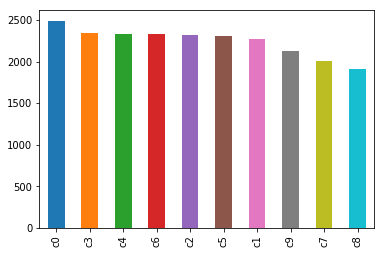

In [10]:
df['classname'].value_counts().plot(kind='bar')

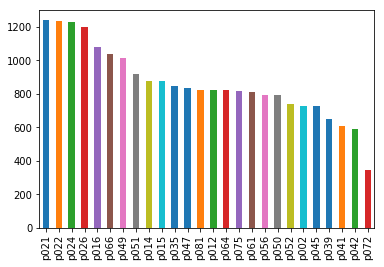

In [11]:
df['subject'].value_counts().plot(kind='bar')

In [12]:
drivers = pd.unique(df.subject)
drivers

array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045',
       'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'], dtype=object)

In [13]:
# Reproducibility

np.random.seed(42)
torch.manual_seed(42)

According to the rules of the competition, drivers appear either in train set or test set. So we create validation set with a subset of drivers to better represent the real test set.

In [14]:
valid_drivers = np.random.permutation(int(len(drivers) * 0.20))
valid_drivers

array([1, 4, 2, 0, 3])

In [15]:
drivers

array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045',
       'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'], dtype=object)

### Cross Validation Across Drivers

Divide training and validation data according to drivers to mirror the test set.

In [17]:
k = KFold(len(drivers), n_folds=5, shuffle=True, random_state=38)

In [18]:
for train_drivers, valid_drivers in k:
    print(train_drivers, valid_drivers)

[ 0  1  2  3  4  7  9 10 11 13 15 16 18 19 20 21 22 23 24 25] [ 5  6  8 12 14 17]
[ 1  2  3  4  5  6  8 10 11 12 13 14 15 16 17 18 19 21 22 23 25] [ 0  7  9 20 24]
[ 0  1  2  4  5  6  7  8  9 10 11 12 14 16 17 19 20 21 22 24 25] [ 3 13 15 18 23]
[ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 17 18 19 20 21 23 24] [ 2 10 16 22 25]
[ 0  2  3  5  6  7  8  9 10 12 13 14 15 16 17 18 20 22 23 24 25] [ 1  4 11 19 21]


In [19]:
path = Path('~/datasets/statefarm').expanduser()

In [20]:
def generate_data(data_df, bs=64, size=224):
    src = (ImageItemList.from_df(data_df, path=path, cols='img', folder='train2')
          .split_from_df('valid')
          .label_from_df('classname')
          .add_test_folder())
    data = (src.transform(get_transforms(do_flip=False, max_rotate=5.0, max_warp=0.2, max_zoom=1.10), size=size)
           .databunch(bs=bs)
           .normalize(imagenet_stats))
    
    return data

In [21]:
def fit_model(df, bs=64, size=224):
    
    arch = models.resnet34
    
    data = generate_data(df, bs, size)
    
    learner = create_cnn(data, arch, metrics=[accuracy])
    
    learner.fit_one_cycle(3, max_lr=1e-2)
    
    learner.unfreeze()
    
    learner.fit_one_cycle(8, max_lr=slice(1e-6, 1e-4))
    
    return learner

In [22]:
predictions = list()
for i, (train_drivers, valid_drivers) in enumerate(k):
    td = drivers[train_drivers]
    vd = drivers[valid_drivers]
    
    df_new = df.copy()
    
    df_new["valid"] = 0
    df_new.loc[df_new.subject.isin(vd), "valid"] = 1
    
    learner = fit_model(df_new)
    
    learner.save(f'fold-{i}')
    
    preds, _ = learner.get_preds(ds_type=DatasetType.Test)
    predictions.append(preds)
    
    gc.collect()

In [53]:
predictions[:2]

[tensor([[2.6252e-02, 2.7782e-02, 1.1654e-03,  ..., 7.1115e-01, 3.3468e-02,
          1.6958e-01],
         [9.4216e-01, 5.0808e-04, 2.1375e-04,  ..., 3.4300e-04, 3.5667e-03,
          5.1493e-02],
         [6.6040e-06, 5.2638e-06, 1.3310e-04,  ..., 7.1781e-05, 6.2357e-04,
          1.4978e-05],
         ...,
         [2.8099e-06, 3.4191e-07, 1.5963e-04,  ..., 9.1942e-07, 1.6680e-03,
          2.0145e-04],
         [1.3513e-01, 8.3647e-05, 1.6916e-05,  ..., 5.3346e-05, 8.5951e-03,
          8.4655e-01],
         [2.7088e-05, 9.5870e-05, 9.9931e-01,  ..., 2.8607e-07, 1.6582e-04,
          3.4434e-04]]),
 tensor([[3.3563e-01, 1.9965e-02, 6.6623e-03,  ..., 4.5122e-02, 9.1145e-02,
          3.6529e-01],
         [2.7579e-01, 2.2595e-05, 7.9218e-07,  ..., 1.4835e-04, 1.5501e-02,
          7.0842e-01],
         [5.5937e-07, 7.4180e-08, 2.7862e-06,  ..., 1.1408e-07, 2.1637e-06,
          3.1137e-07],
         ...,
         [8.4757e-06, 1.5386e-07, 7.6960e-06,  ..., 2.6837e-05, 3.1266e-03,
   

### Generate Predictions

In [26]:
predictions_np = list(map(lambda x: x.numpy(), predictions))

In [51]:
predictions_np[:2]

[array([[2.625153e-02, 2.778157e-02, 1.165425e-03, 5.425558e-03, ..., 6.333518e-03, 7.111509e-01, 3.346812e-02,
         1.695812e-01],
        [9.421552e-01, 5.080811e-04, 2.137502e-04, 1.308326e-04, ..., 6.866215e-04, 3.429972e-04, 3.566668e-03,
         5.149271e-02],
        [6.604005e-06, 5.263846e-06, 1.331049e-04, 2.318554e-05, ..., 2.598193e-05, 7.178071e-05, 6.235706e-04,
         1.497801e-05],
        [3.842815e-06, 4.331436e-09, 2.427208e-10, 1.406823e-07, ..., 1.712803e-08, 1.419062e-07, 3.421439e-07,
         1.510377e-05],
        ...,
        [1.631010e-09, 3.539923e-11, 2.493509e-10, 2.183462e-09, ..., 1.739399e-10, 2.049749e-09, 3.337736e-09,
         9.555454e-08],
        [2.809942e-06, 3.419067e-07, 1.596317e-04, 4.498103e-07, ..., 9.979565e-01, 9.194201e-07, 1.668018e-03,
         2.014515e-04],
        [1.351296e-01, 8.364730e-05, 1.691603e-05, 7.800174e-03, ..., 1.018813e-03, 5.334621e-05, 8.595122e-03,
         8.465487e-01],
        [2.708820e-05, 9.586955e-05

In [29]:
np.stack(predictions_np).shape

(5, 79726, 10)

In [30]:
preds_avg = np.average(np.stack(predictions_np), axis=0)

In [32]:
preds_avg.shape

(79726, 10)

In [39]:
data = generate_data(df_new)

In [40]:
data.test_ds.items

array([PosixPath('/home/nihargajre/datasets/statefarm/test/img_82315.jpg'),
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_42500.jpg'),
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_73683.jpg'),
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_403.jpg'), ...,
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_39924.jpg'),
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_69461.jpg'),
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_80279.jpg'),
       PosixPath('/home/nihargajre/datasets/statefarm/test/img_75951.jpg')], dtype=object)

In [41]:
subm_df = pd.read_csv('sample_submission.csv')
subm_df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [42]:
preds_df = pd.DataFrame(preds_avg, columns=[f'c{i}' for i in range(0, 10)])
preds_df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0.072749,9.643327e-03,1.753440e-03,0.007131,0.024222,0.001202,0.002161,0.728382,0.025069,0.127686
1,0.338652,5.745593e-04,9.076547e-05,0.000166,0.000624,0.000374,0.000555,0.000611,0.015410,0.642943
2,0.000333,4.626042e-06,2.232624e-03,0.000072,0.996181,0.000014,0.000049,0.000078,0.000975,0.000060
3,0.000094,1.958470e-07,1.817063e-07,0.000120,0.000024,0.917951,0.000010,0.000018,0.000163,0.081619
4,0.000004,4.427725e-06,1.239486e-03,0.000003,0.000022,0.000006,0.000017,0.000244,0.998056,0.000404


In [43]:
imgs = list(map(lambda x: Path(x).parts[-1], data.test_ds.items))
imgs[:5]

['img_82315.jpg',
 'img_42500.jpg',
 'img_73683.jpg',
 'img_403.jpg',
 'img_89545.jpg']

In [44]:
preds_df["img"] = imgs

In [45]:
preds_df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,img
0,0.072749,9.643327e-03,1.753440e-03,0.007131,0.024222,0.001202,0.002161,0.728382,0.025069,0.127686,img_82315.jpg
1,0.338652,5.745593e-04,9.076547e-05,0.000166,0.000624,0.000374,0.000555,0.000611,0.015410,0.642943,img_42500.jpg
2,0.000333,4.626042e-06,2.232624e-03,0.000072,0.996181,0.000014,0.000049,0.000078,0.000975,0.000060,img_73683.jpg
3,0.000094,1.958470e-07,1.817063e-07,0.000120,0.000024,0.917951,0.000010,0.000018,0.000163,0.081619,img_403.jpg
4,0.000004,4.427725e-06,1.239486e-03,0.000003,0.000022,0.000006,0.000017,0.000244,0.998056,0.000404,img_89545.jpg


In [47]:
preds_df[['img'] + [f'c{i}' for i in range(0, 10)]].to_csv('sub.3.csv', index=False, float_format='%.5f')

In [48]:
from IPython.display import FileLink

In [49]:
FileLink('sub.3.csv')

/home/nihargajre/datasets/statefarm/sub.3.csv

In [50]:
!head -n 5 sub.3.csv

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_82315.jpg,0.07275,0.00964,0.00175,0.00713,0.02422,0.00120,0.00216,0.72838,0.02507,0.12769
img_42500.jpg,0.33865,0.00057,0.00009,0.00017,0.00062,0.00037,0.00055,0.00061,0.01541,0.64294
img_73683.jpg,0.00033,0.00000,0.00223,0.00007,0.99618,0.00001,0.00005,0.00008,0.00098,0.00006
img_403.jpg,0.00009,0.00000,0.00000,0.00012,0.00002,0.91795,0.00001,0.00002,0.00016,0.08162


LB Score: __0.25033__